# Hysteresis Processing

## Install and import packages

In [1]:
import rockmag as rmag
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
import pandas as pd
import numpy as np
from numpy.linalg import svd, lstsq
pd.set_option('display.max_columns', 500)
import ipywidgets as widgets


import matplotlib.pyplot as plt
import math
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.display import display, HTML, clear_output, Javascript 

## Import data

To pull data from MagIC, you need to define 3 parameters below:
 - `magic_id`
 - `share_key`
 - `dir_path`
 
### If you are pulling data off of an existing, published dataset on MagIC:
 - look for the MagIC contribution link associated with the dataset
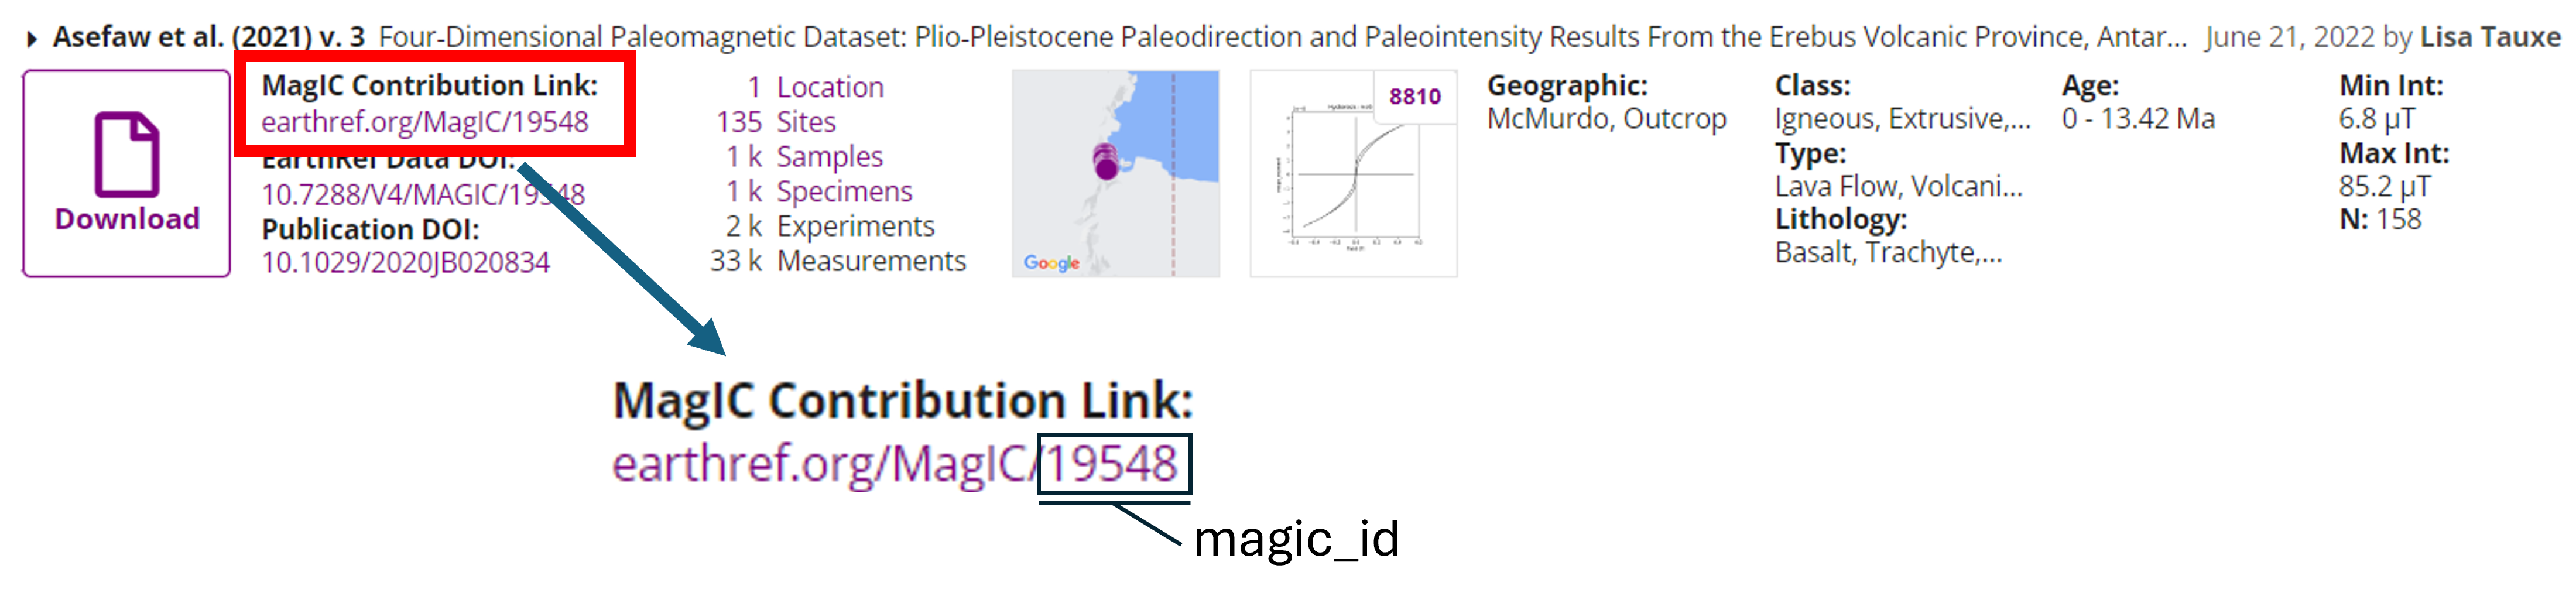
 - leave the share key blank `share_key = ''`
 - set the dir_path to where you want the data to be stored
 
### If you are pulling date off of a private MagIC contribution:
 - find the contribution in your private workspace and click on share
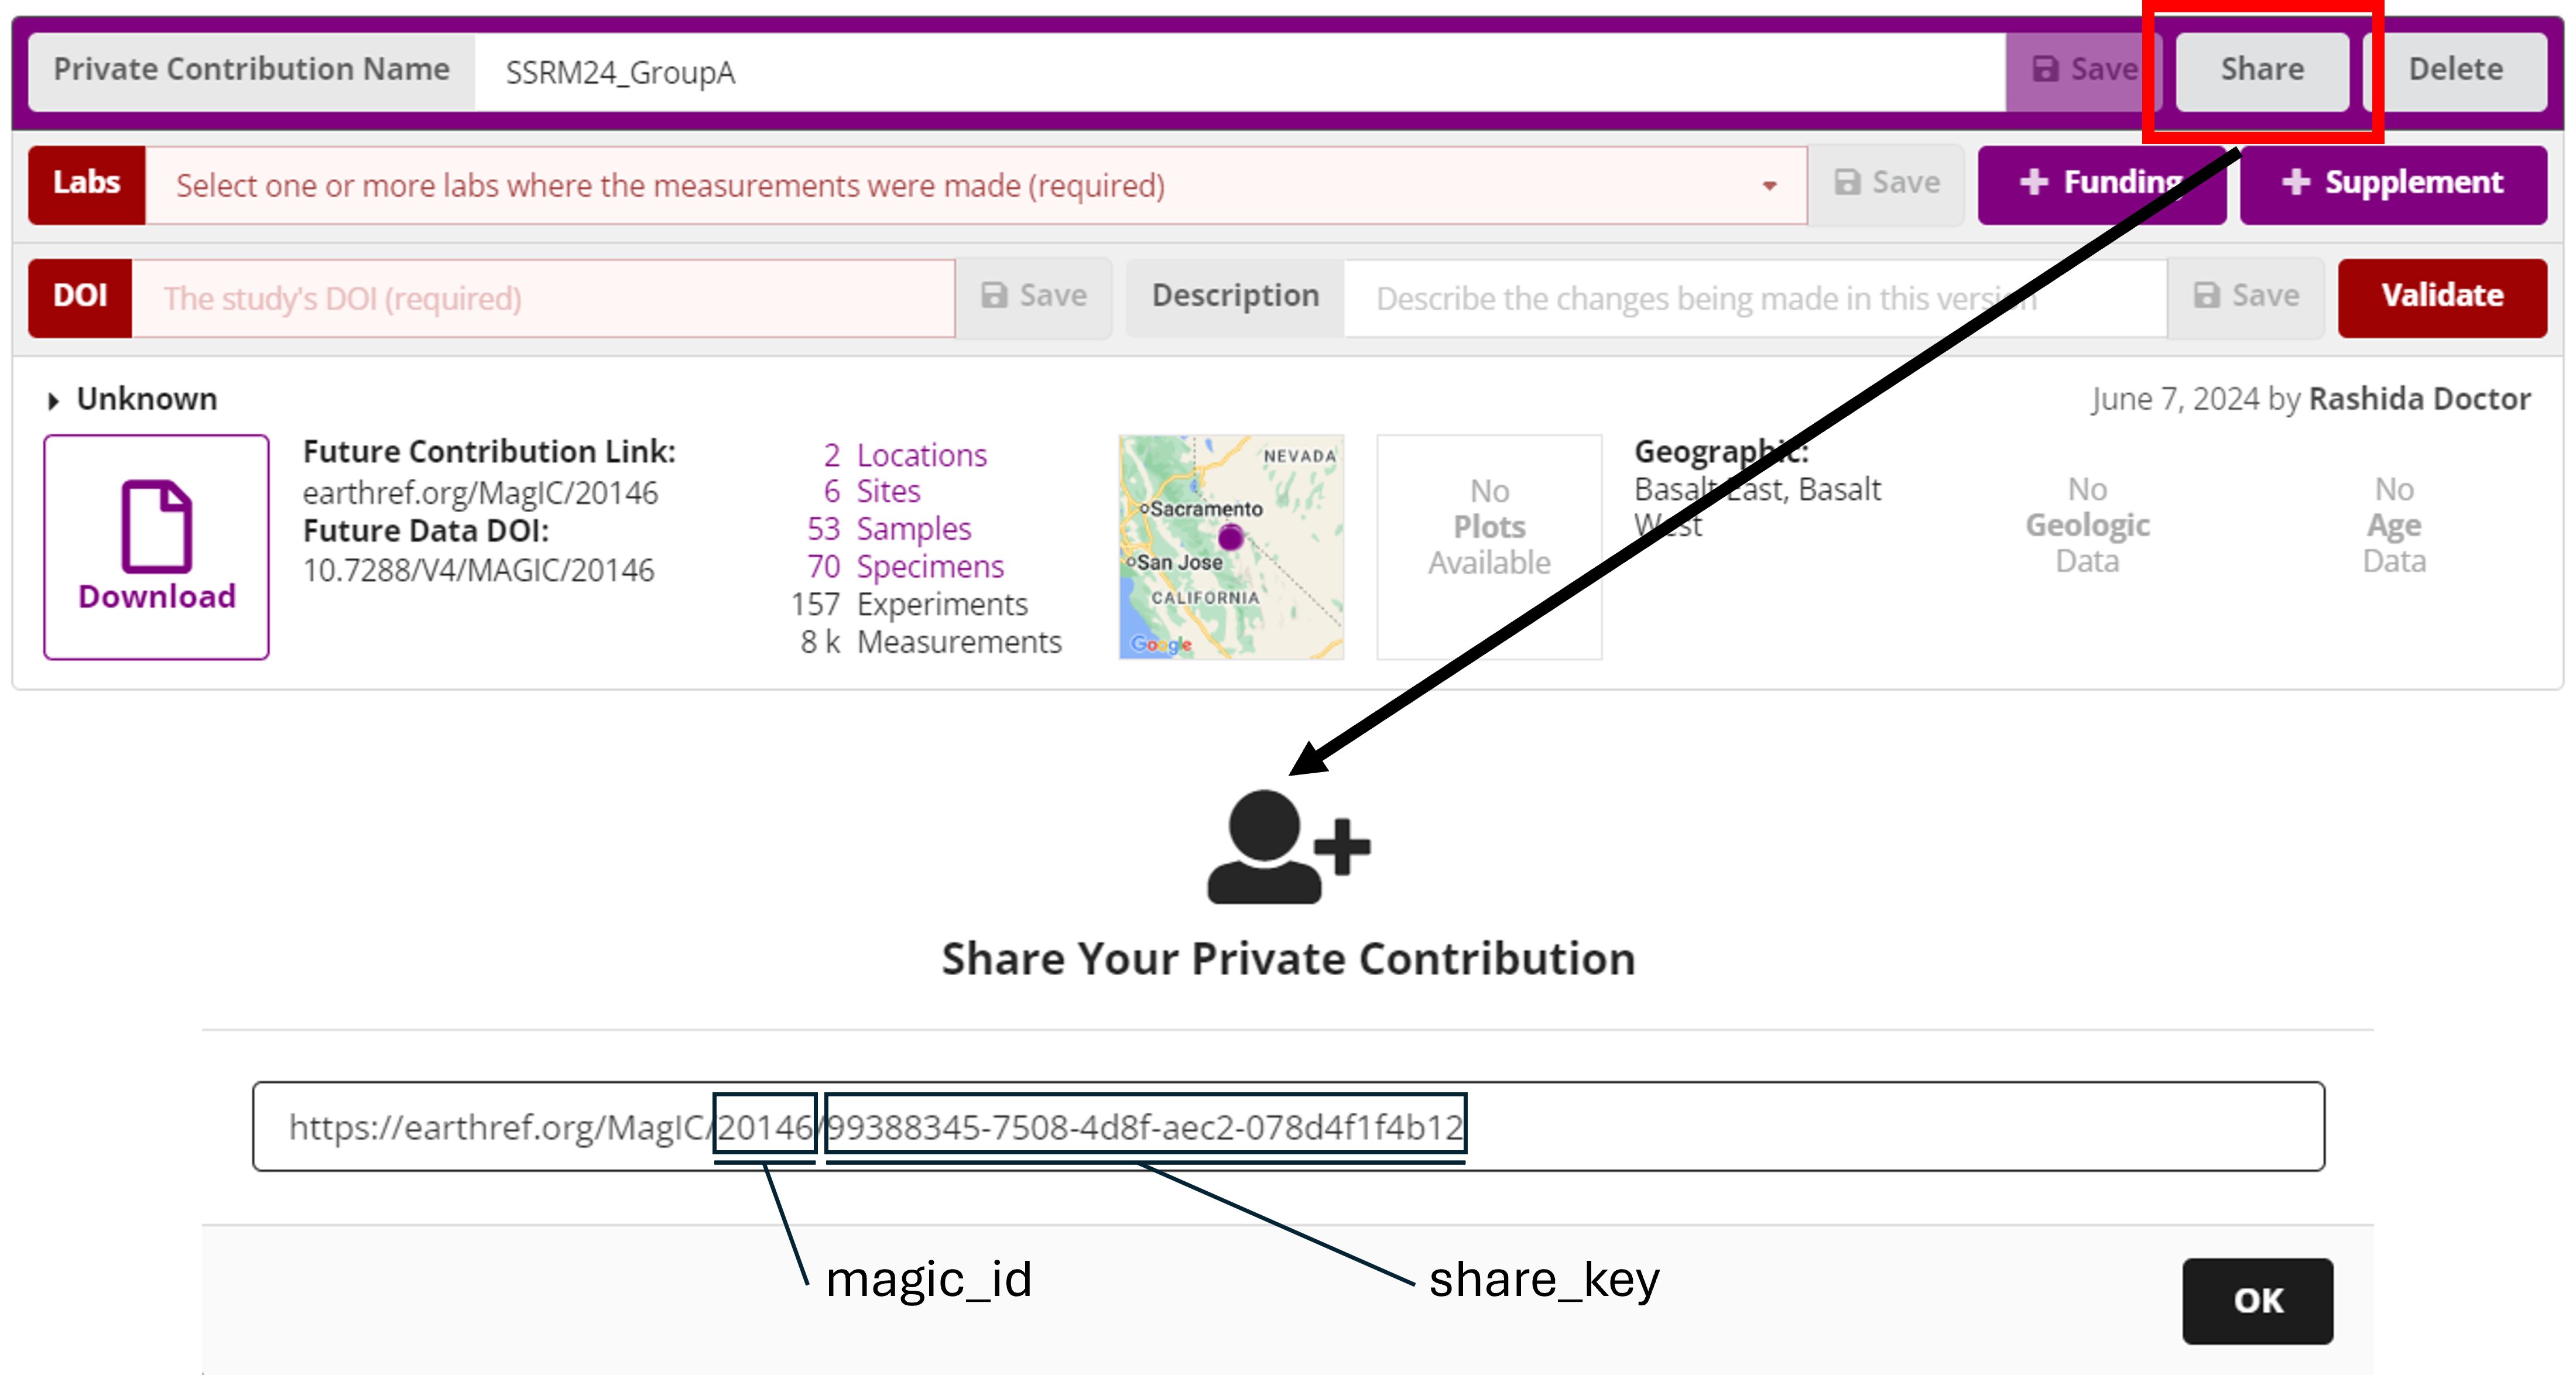
- set the dir_path to where you want the data to be stored

In [ ]:
#define these three parameters to match your data
magic_id = '19216'
share_key = ''
dir_path = 'example_data/hyst'

result, magic_file = ipmag.download_magic_from_id(magic_id, directory=dir_path, share_key=share_key)
ipmag.unpack_magic(magic_file, dir_path)
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df
measurements.dropna(axis=1, how='all')

## Local Data
If the magic file is already saved on your computer, use this instead. Set the file location under dir_path.

In [2]:
# set the dir_path to the directory where the measurements.txt file is located
dir_path = './example_data/hyst/ECMB'

# set the name of the MagIC file
ipmag.unpack_magic('ECMB.TXT', 
                     dir_path = dir_path,
                     input_dir_path = dir_path)

# create a contribution object from the tables in the directory
contribution = cb.Contribution(dir_path)
measurements = contribution.tables['measurements'].df

working on:  'specimens\r'
26  records written to file  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\ECMB\specimens.txt
  data put in  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\ECMB\specimens.txt
working on:  'samples\r'
8  records written to file  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\ECMB\samples.txt
  data put in  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\ECMB\samples.txt
working on:  'sites\r'
8  records written to file  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\ECMB\sites.txt
  data put in  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\ECMB\sites.txt
working on:  'locations\r'
16  records written to file  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\ECMB\locations.txt
  data put in  C:\Users\docto\Documents\GitHub\RockmagPy-notebooks\example_data\hyst\ECMB\locations.txt
working on:  'measuremen

## All of the project data is now stored in the $measurements$ variable

The method codes relevent to hysteresis loops are:
 - `LP-HYS` for regular hysteresis loops
 - `LP-HYS-O` for hysteresis loops as a function of orientation
 - `LP-HYS-T` for hysteresis loops as a function of temperature

In [3]:
# plot the hysteresis loop (only looking for 'LP-HYS')
data_type = rmag.make_hyst_plots(measurements)

Dropdown(description='Specimen:', options=('NED1-5c', 'NED18-2c', 'NED2-8c', 'NED23-8c', 'NED34-6c', 'NED36-8c…

RadioButtons(description='Plot with:', options=(('matplotlib', False), ('plotly', True)), value=False)

RadioButtons(description='Units:', options=(('Mass normalized', 'magn_mass'), ('Moment Am^2', 'magn_moment'), …

Output()

In [4]:
# select method code, specimen, and experiment that you want to focus on
method, specimen, experiment = rmag.interactive_method_specimen_selection_hyst(measurements)

Dropdown(description='Method Code:', options=('LP-HYS',), value='LP-HYS')

Dropdown(description='Specimen:', options=('NED1-5c', 'NED18-2c', 'NED2-8c', 'NED23-8c', 'NED34-6c', 'NED36-8c…

Dropdown(description='Experiment:', options=('IRM-VSM3-LP-HYS-218845', 'IRM-VSM3-LP-BCR-BF-218846'), value='IR…

In [5]:
# extract the specimen specific data
hyst_data = rmag.extract_hysteresis_data(measurements, specimen.value)

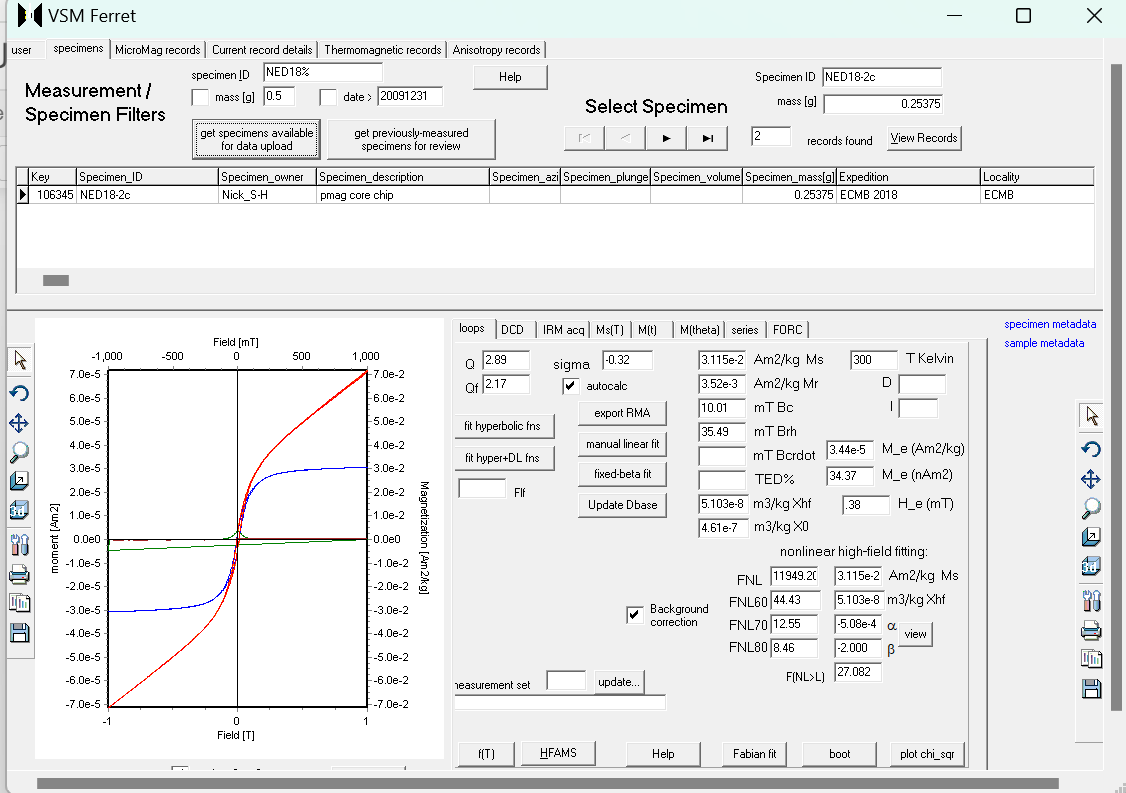

# Loop processing

Conventional loop processing involves fitting a line to the high field data. At these high fields, the remanance carrying moments are assumed to be saturated. The intercept of the fitted line would give the saturation magnetization ($M_s$) and the slope would be the high field susceptibility of the ($\chi_{HF}$). However, the high field magnetizations are often non-linear and conventional methods do not include a measurement of data quality. Here, we will follow the steps to processing hysteresis loops laid out by *Jackson & Solheid (2010)*.


### Gridding
The first step to loop processing involve gridding the data to be equally spaced. Linearly interpolating between the points perserves the the noise in the data for statistical interpretation. In this first step, we will set the offsets along the B and M axes to zero.

In [6]:
# pull out moment and field data
loop_moments = hyst_data[data_type.value] # value set by dropdown box above
loop_fields = hyst_data['meas_field_dc']

# number of points in the hysteresis loop
n_loop = len(loop_fields)

# linear interpolation
polydegree = 1

# smoothing factor, should be odd
nsmooth = 3

# offsets to center the loop - start with 0
B_offset = 0
M_offset = 0

acheckvar= 0

print('Variables set!')

Variables set!


In [7]:
# first call to loop_grid ignores offsets
grid_fields, grid_moments =rmag.loop_grid(n_loop, polydegree, nsmooth, loop_fields, loop_moments, B_offset, M_offset)

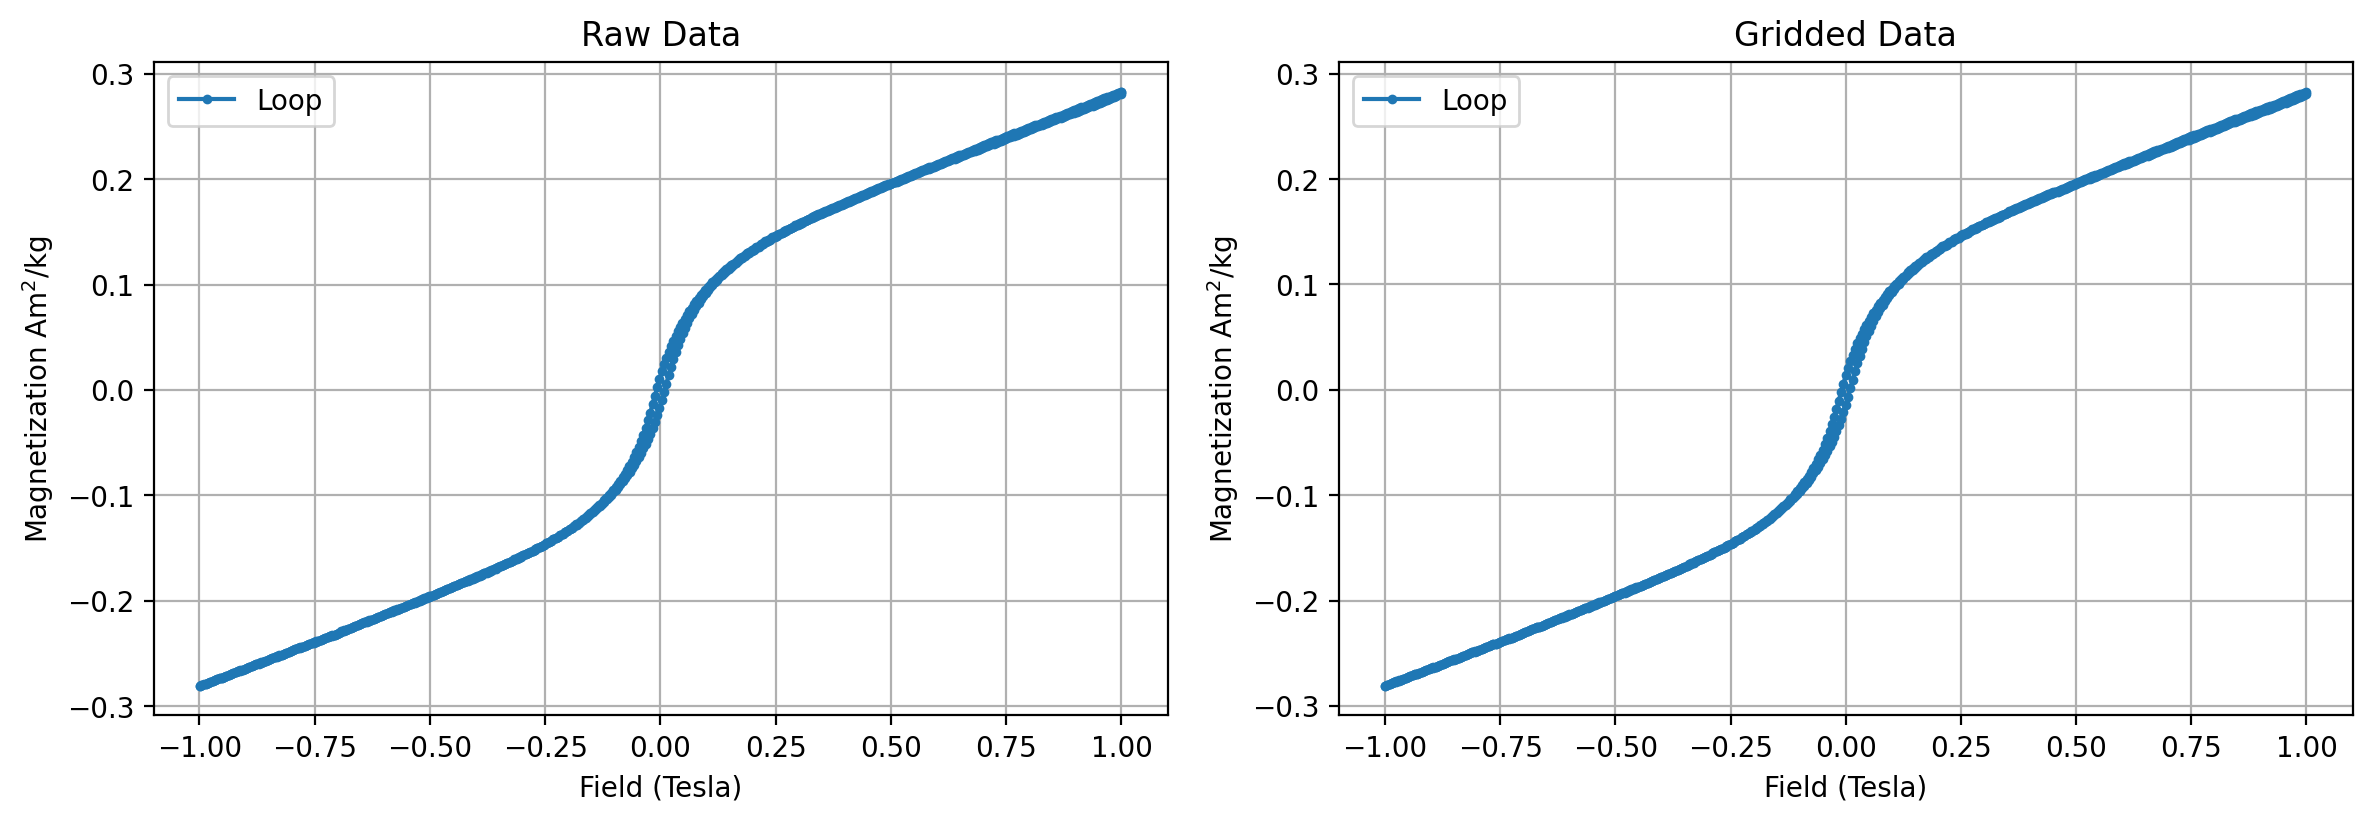

In [8]:
# in matplotlib
g_fig, g_axs = rmag.plot_hyst_data(fields = loop_fields, moments = loop_moments, data_type = data_type.value, \
                                   return_figure = True, double_plot = True, fields1 = grid_fields, \
                                   moments1 = grid_moments)

# only for matplotlib
g_axs[0].set_title('Raw Data')
g_axs[1].set_title('Gridded Data')
plt.show()

Ideally, these two should be virtually indistinguishable...

## Remanent Hesteretic

Hysteresis loops can be split into reversible and irreversible components. The irreversible component is due to processes like discontinuous domain wall displacement or domain nucleation and extinction and is responsible for the seperation of the loop (von Dobeneck, 1996).

We can calculate the irreversible component by calculating the difference between the upper and lower branch of the hysteresis loop:
$$ M_{rh} = {{M_+ - M_-} \over {2}} $$

In [23]:
moment_sub = rmag.branch_sub(n_loop, grid_moments)

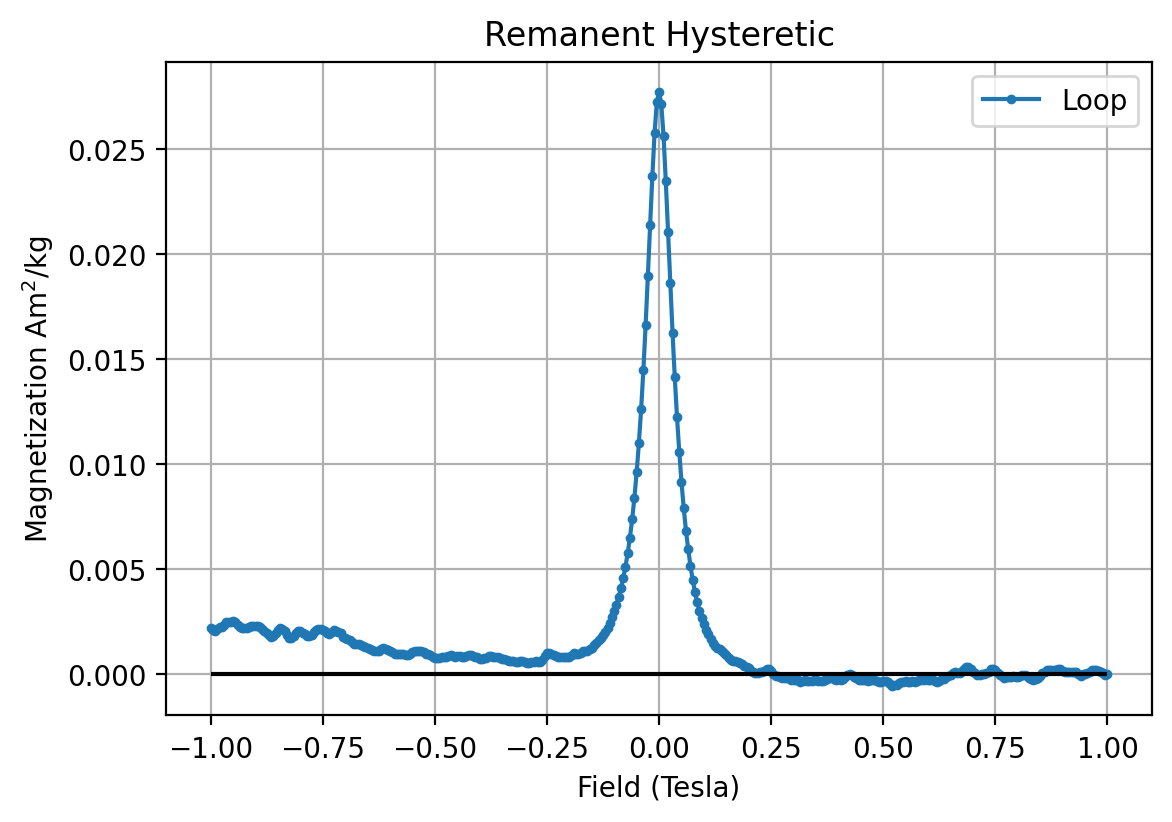

In [24]:
# in matplotlib
Mrh_fig, Mrh_axs = rmag.plot_hyst_data(fields = grid_fields[len(moment_sub):], moments = moment_sub,\
                                   data_type = data_type.value, return_figure = True)
Mrh_axs.hlines(0, min(grid_fields), max(grid_fields), color = 'k')

# only for matplotlib
Mrh_axs.set_title('Remanent Hysteretic')
plt.show()

In [ ]:
n_looppoints = n_loop
FNL, slope, intercept = rmag.loop_test_linearity(n_looppoints, grid_fields, grid_moments)
print("FNL = ",FNL)
print("slope = ",slope)
print("intercept = ",intercept)

In [ ]:
M_offset, B_offset, M_sn = rmag.loop_errorcal(n_looppoints, grid_fields, grid_moments);
print('good luck')
print("M_offset = ",M_offset)
print("B_offset = ",B_offset)

"""
A quality factor Q is calculated for both the whole curve, Q, and the ferromagnetic part, Qf.
Q is the decimal log of the signal/noise ratio, calculated from the mean square mismatch
between symmetrically equivalent moments, and typically ranges between 0 (s/n~1) and ~3 (s/n~1000).
A higher value indicates better quality data.

"""


if M_sn > 0:
    Q = math.log(M_sn, 10) * -1
else:
    Q = 10
print("Q = ",Q)

In [ ]:
# second call to grid routine removes offsets
grid_fields, grid_moments = rmag.loop_grid(n_loop, polydegree, nsmooth, loop_fields, loop_moments, B_offset, M_offset)
print ("grid_moments = ",grid_moments[0])
print ("grid_fields = ",grid_fields[0])

In [ ]:
ErrX, ErrY = rmag.loop_errorcal2(n_looppoints, grid_fields, grid_moments, 0, 0)
for i in range(10):
    print("error x and y = ",ErrX[i],", ",ErrY[i])


M_err = 0
for i in range(0, n_looppoints//2 -2):
    M_err += (ErrY[i])**2
M_err = math.sqrt(M_err / (n_looppoints//2 ) )
print("n_looppoints = ", n_looppoints//2)
print("M_err = ", M_err)

In [ ]:
mrh, E_hys, Brh, Bih = rmag.loop_delta_M(n_looppoints, grid_fields, grid_moments)
print('loop_delta_m first go')
#print("mrh =", mrh)
print("E_hys =", E_hys)
print("Brh =", Brh)
print("Bih =", Bih)

plt.subplot(1,4,1)
plt.plot(loop_fields, loop_moments)

plt.subplot(1,4,2)
plt.plot(grid_fields, grid_moments)

xpoints = grid_fields[n_loop // 2:]
apoints = grid_fields[n_loop // 2:]
plt.subplot(1,4,3)
ypoints = moment_sub
plt.plot(xpoints, ypoints)

plt.subplot(1,4,4)
zpoints = mrh[:-1]
plt.plot(apoints, zpoints)
plt.show()